### 이 파일이 이미지로 점수 예측하는 코드입니다. 

# 0. 실행할 부분

In [1]:

#목표: 산점도

# 작업1: 1페이지들로만 train, test
# 작업2: 모든페이지로 train, 1페이지들만 test

# torchvision 관련 라이브러리 import

from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

/nfs/home/dailyavenger/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install jsonlines
!pip install pdf2image  

In [3]:
#@title

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models



In [4]:
#@title
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import glob
from PIL import Image
import jsonlines
import os
from tqdm import tqdm

#1. 데이터셋 로드


In [5]:
#@title
import cv2
class PaperDataSet(Dataset):
    def __init__(self, overall_image_path, transform=None):
        print("initialize data sets")
        self.transform = transform
        rating_dict = {}
        self.image_list = list()
        self.score_list = list()
        years = ["2021"]
        lst_ = [ "UH-cmocLJC", "mNtmhaDkAr",  "UiLl8yjh57",  "kB8DkEKSDH", "cL4wkyoxyDJ"]
        for year in years:
            cnt = 0
            year_image_path = overall_image_path
            # year_image_path = overall_image_path+"iclr"+year+"/"
            # *********** 경로 수정 ***********
            with jsonlines.open(f"iclr{year}_metadata.jsonl") as read_file:
                for line in read_file.iter():
                    rating_dict[line['forum']] = line['rating']
            input_paths = os.listdir(year_image_path)
            for one_file_image_path in tqdm(input_paths, desc="make data set"):
                if one_file_image_path not in lst_:
                  image_path = year_image_path + one_file_image_path + "/"
                  before_add_size = len(self.image_list)
                  self.image_list.extend(glob.glob(image_path + "*.bin")) # glob: 폴더 내의 파일 찾아줌
                  rating = rating_dict[one_file_image_path]
                  self.score_list.extend([rating] * (len(self.image_list)-before_add_size))
                  cnt += len(self.image_list)-before_add_size
                else:
                  print(one_file_image_path, "is in lst_")
            print(f"{year}: {cnt}")

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        label = self.score_list[idx]
        binary_file = image_path   # binary_file = dataset/image/iclr2021/_0kaDkv3dVf/3.bin 
        with open(binary_file, 'rb') as f:
            data = f.read()
        encoded_img = np.fromstring(data, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [6]:
image_path =  "../wngusrud27/dataset/image/iclr2021/" 
image_path2 =  "temp/" 
dataset_file_name = 'iclr2021_dataset.pt'

In [7]:
#zip_path = image_path + "iclr2021_binary.zip"

#!mkdir binary

#!cp {zip_path} ./iclr2021.zip

#!unzip -q ./iclr2021.zip -d ./binary/ 

#!rm ./iclr2021.zip

In [8]:
def make_save_data_set(image_path2, dataset_file_name):
  print("start to make data set")
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

  dataset = PaperDataSet(image_path, transform=transform)
  print(f"data set length: {dataset.__len__()}")

  torch.save(dataset, image_path2 + dataset_file_name)
  print("save data sets")

In [9]:
#image_path =  "./binary/" 
make_save_data_set(image_path2, dataset_file_name)
# data_set_usage_ex(dataset_file_name)

start to make data set
initialize data sets


make data set:  29%|██▉       | 757/2594 [00:00<00:01, 1526.29it/s]

kB8DkEKSDH is in lst_


make data set:  43%|████▎     | 1103/2594 [00:00<00:00, 1646.85it/s]

UiLl8yjh57 is in lst_
mNtmhaDkAr is in lst_
UH-cmocLJC is in lst_


make data set:  69%|██████▉   | 1791/2594 [00:01<00:00, 1700.41it/s]

cL4wkyoxyDJ is in lst_


make data set: 100%|██████████| 2594/2594 [00:01<00:00, 1536.47it/s]

2021: 23301
data set length: 23301
save data sets


In [10]:
from torch.utils.data.dataset import random_split
import torchvision.datasets as dset

dataset = torch.load(dataset_file_name)

train_size = int(0.8 * len(dataset))
print("train size:", train_size-1)

test_size = len(dataset) - train_size
print("test size:", test_size+1)
# validation 
train_dataset, test_dataset = random_split(dataset, [train_size-1,test_size+1])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

train size: 18675
test size: 4671


# 2 모델 생성,하이퍼 파라미터 설정

In [11]:
from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정

resnet50 = models.resnet50(pretrained=False).to(device) # true 옵션으로 사전 학습된 모델을 로드

# transfer learning 사용 시 추가 
# if using_transfer_learning:|
#   for param in resnet50.parameters():
#     param.requires_grad = False

model = nn.Sequential(
    resnet50,
    nn.Flatten(),
    nn.Linear(1000, 256),
    nn.ReLU(),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(device)


In [12]:
import torch
import torch.nn as nn
from torch import optim
lr = 0.0001
num_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)

In [13]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_dataloader,
    'test_dataloader': test_dataloader,
    'device':device
}

# 3. 학습

In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
import time
import datetime
from numpy import vstack

def train(model, params):
  total_start = time.time()
  loss_function=params["loss_function"]
  train_dataloader=params["train_dataloader"]
  test_dataloader=params["test_dataloader"]
  device=params["device"]

  print("start train")
  print("train size:", train_size-1)
  print("test size:", test_size+1)
  for epoch in range(0, num_epochs):
      
    model.train()
    epoch_start = time.time()
    trained_number = 0
    i2=0
    for i, data in enumerate(train_dataloader):  
      i2=i
      #if(i%9!=3): continue         
        # train dataloader 로 불러온 데이터에서 이미지와 라벨을 분리
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)
        
        # 이전 batch에서 계산된 가중치를 초기화
      optimizer.zero_grad()
        # forward + back propagation 연산
      outputs = model(inputs).squeeze()
      train_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32))
      train_loss.backward()
      optimizer.step()
      trained_number += labels.size(0)
        
        #if i%100==0:
          #print(f"epoch {epoch+1} {trained_number/train_size*100*9}% train finish")
      #print(f"epoch {epoch+1} train finish") 

    print(f"{epoch+1} pages amount: {i2}")
      
    model.eval()
      # test accuracy 계산
    total = 0
    correct = 0
    loss = 0
    score_list = list()   ##새로 추가
    predict_list = list()  ##새로 추가
    for i, data in enumerate(test_dataloader, 0):
      i2=i
      #if(i%10!=0): continue
        #if(i%9!=2): continue
      inputs, labels = data        
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)
        

        # 결과값 연산
      outputs = model(inputs).squeeze()
      score_list.extend(labels.detach().cpu().numpy()) ##새로 추가

      predict_list.extend(outputs.detach().cpu().numpy())## 새로추가
 
        # i_batch_size = labels.size(0)
        # total += i_batch_size
        # correct += (abs(outputs - labels)<0.5).sum().item() # 변경될 수 있음 
        # test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
        # loss += i_batch_size * test_loss
        #if i%20==0:
          #print(f"epoch {epoch+1} {total/test_size*100*9}% test finish")
        # break
      
    import matplotlib.pyplot as plt ##새로 추가
    plt.scatter(score_list,predict_list) ##새로 추가 .numpy()
    plt.xlabel('evaluation score')
    plt.ylabel('predicted score')
    plt.show() ##새로 추가

      # 학습 결과 출력
    print(f"{epoch+1} pages amount: {i2}")
      #print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f' %(epoch+1, num_epochs, train_loss.item(), loss/total, 100*correct/total))
      
      
      #epoch_elapsed_time = time.time() - epoch_start
      #epoch_elapsed_time_list = str(datetime.timedelta(seconds=epoch_elapsed_time)).split(".")
      #total_elapsed_time = time.time() - total_start
      #total_elapsed_time_list = str(datetime.timedelta(seconds=total_elapsed_time)).split(".")
      #print(f"Epoch {epoch+1} Elapsed time is {epoch_elapsed_time_list[0]}")  
      #print(f"Total Elapsed time is {total_elapsed_time_list[0]}")  


start train
train size: 18675
test size: 4671


/tmp/ipykernel_2270225/3534566208.py:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img = np.fromstring(data, dtype=np.uint8)


1 pages amount: 291


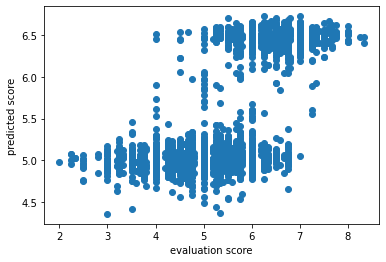

1 pages amount: 145
2 pages amount: 291


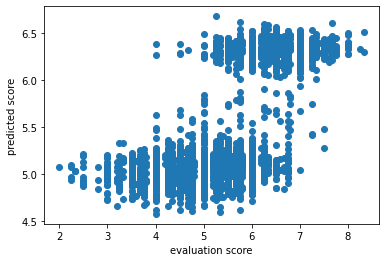

2 pages amount: 145
3 pages amount: 291


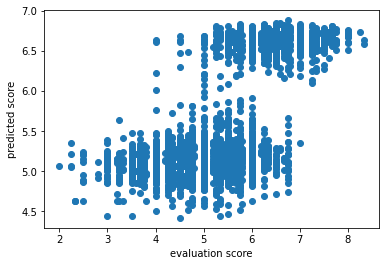

3 pages amount: 145
4 pages amount: 291


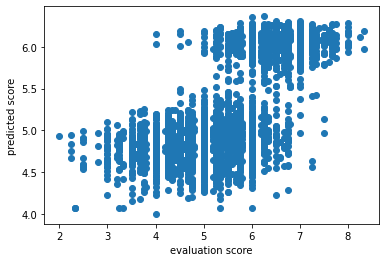

4 pages amount: 145
5 pages amount: 291


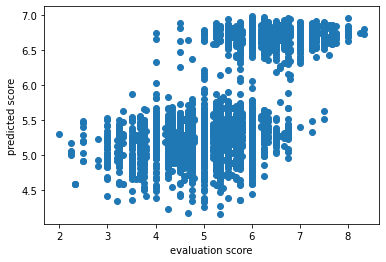

5 pages amount: 145


In [18]:
import gc
gc.collect()               
torch.cuda.empty_cache()
train(model, params)

In [ ]:
+=1
#torch.save(model.state_dict(), "temp/model1" )

#torch.save(model, "temp2/model2" )

SyntaxError: invalid syntax (3083572999.py, line 1)

: 

## 테스트

In [ ]:
#@title
import cv2
class TestDataSet(Dataset):
    def __init__(self, overall_image_path, transform=None):
        print("initialize data sets")
        self.transform = transform
        rating_dict = {}
        self.image_list = list()
        self.score_list = list()
        cnt = 0
        year_image_path = overall_image_path
        # year_image_path = overall_image_path+"iclr"+year+"/"
        with jsonlines.open(f"drive/Shareddrives/소종-논문/iclr2021_metadata.jsonl") as read_file:
            for line in read_file.iter():
                rating_dict[line['forum']] = line['rating']
        input_paths = os.listdir(year_image_path)
        input_paths.sort()
        for one_file_image_path in tqdm(input_paths, desc="make data set"):
            image_path = year_image_path + one_file_image_path + "/"
            before_add_size = len(self.image_list)
            imgs = glob.glob(image_path + "1.bin")
            imgs.sort()
            self.image_list.extend(imgs) # glob: 폴더 내의 파일 찾아줌
            rating = rating_dict[one_file_image_path]
            self.score_list.extend([rating] * (len(self.image_list)-before_add_size))
            cnt += len(self.image_list)-before_add_size

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        label = self.score_list[idx]
        binary_file = image_path   # binary_file = dataset/image/iclr2021/_0kaDkv3dVf/3.bin 
        with open(binary_file, 'rb') as f:
            data = f.read()
        encoded_img = np.fromstring(data, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def img_list(self):
      print(self.image_list)

In [ ]:
image_path = "drive/Shareddrives/소종-논문/test/binary/occlusion/" 
dataset_file_name = 'iclr2021_dataset_test.pt'

In [ ]:
def test_make_save_data_set(image_path, dataset_file_name):
  print("start to make data set")
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

  dataset = TestDataSet(image_path, transform=transform)
  print(f"data set length: {dataset.__len__()}")

  torch.save(dataset, dataset_file_name)
  print("save data sets")

In [ ]:
test_make_save_data_set(image_path, dataset_file_name)

start to make data set
initialize data sets


FileNotFoundError: [Errno 2] No such file or directory: 'drive/Shareddrives/소종-논문/iclr2021_metadata.jsonl'

In [ ]:
from torch.utils.data.dataset import random_split
import torchvision.datasets as dset

dataset = torch.load(dataset_file_name)

test_size = len(dataset)
print("test size:", test_size)
# validation 

dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=False)

/nfs/home/dailyavenger/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'torch' is not defined

In [ ]:
import time
import datetime
from numpy import vstack

def test(model, params):
    total_start = time.time()
    loss_function=params["loss_function"]
    test_dataloader=dataloader
    device=params["device"]

    print("start train")
    print("test size:", test_size)

    # test accuracy 계산
    total = 0
    correct = 0
    loss = 0
    model.eval()
    
    for i, data in enumerate(test_dataloader, 0):
      print("i:", i)
      
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)

      print("size:",labels.size(0))
      print("label:", labels)
      

      # 결과값 연산
      outputs = model(inputs).squeeze()
      print("output:", outputs)
      i_batch_size = labels.size(0)
      total += i_batch_size
      correct += (abs(outputs - labels)<0.5).sum().item() # 변경될 수 있음 
      test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
      loss += i_batch_size * test_loss

      # 학습 결과 출력
    print('Test loss: %.6f, Accuracy: %.2f' %(loss/total, 100*correct/total))

    total_elapsed_time = time.time() - total_start
    total_elapsed_time_list = str(datetime.timedelta(seconds=total_elapsed_time)).split(".")
    print(f"Total Elapsed time is {total_elapsed_time_list[0]}")  

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
test(model, params)

start train
test size: 45
i: 0
size: 32
label: tensor([8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500,
        5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        4.0000, 4.0000, 4.0000, 4.0000, 4.0000], device='cuda:0')
output: tensor([6.5816, 6.5845, 6.5476, 6.7172, 6.5774, 6.7502, 6.5787, 6.6212, 6.6677,
        5.2512, 4.5495, 5.4114, 5.3056, 5.1830, 4.2590, 5.1306, 4.4159, 5.0974,
        4.9216, 4.9011, 4.5559, 5.0236, 4.7439, 5.2108, 4.7982, 5.3017, 4.9362,
        4.7339, 4.6832, 5.0069, 4.9728, 4.8730], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


i: 1
size: 13
label: tensor([4., 4., 4., 4., 7., 7., 7., 7., 7., 7., 7., 7., 7.], device='cuda:0')
output: tensor([5.2232, 4.7544, 4.4490, 4.9124, 6.6159, 6.6060, 6.7244, 6.4929, 6.6800,
        6.5359, 6.5436, 6.2699, 6.6201], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Test loss: 2.917464, Accuracy: 31.11
Total Elapsed time is 0:00:00


## 안쓰는 코드

In [ ]:
lst = list()
with jsonlines.open("iclr2021_metadata.jsonl") as read_file:
  for line in read_file.iter():
    lst.append(float(line['rating']))
avg = sum(lst)/len(lst)
print(avg)

In [ ]:
avg_lst = [avg] * len(lst)
loss_function = nn.MSELoss()
test_loss = loss_function(torch.Tensor(lst).to(torch.float32), torch.Tensor(avg_lst).to(torch.float32)).item()
print(test_loss)

In [ ]:
total = 0
loss = 0
for i, data in enumerate(test_dataloader, 0):
  inputs, labels = data
  inputs = inputs.to(device)
  labels = labels.type(torch.FloatTensor) 
  labels = labels.to(device)
  
  i_batch_size = labels.size(0)
  outputs = [avg] * i_batch_size
  outputs = torch.Tensor(outputs).to(device)
  total += i_batch_size
  test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
  loss += i_batch_size * test_loss

print('loss: %.6f' %(loss/total))

In [ ]:
 from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정

resnet50 = models.resnet50(pretrained=True) # true 옵션으로 사전 학습된 모델을 로드

for param in resnet50.parameters():
    param.requires_grad = False

model2 = nn.Sequential(
    resnet50,
    nn.Flatten(),
    nn.Linear(1000, 256),
    nn.ReLU(),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(device)
